# Identificador de Cliente para risco de crédito

## Sobre:

### Autor:
* Nome: João Gabriel Elvas Ribeiro¶
* Matricula: 190109599
* Github: JoaoGElvas

### Objetivo:
Conseguir distinguir um bom cliente para risco de crédito de um mal cliente para risco de crédito.

## Preparando o ambiente:

Aqui estaremos preparando o ambiente e importando a biblioteca tabular fastai e definindo uma semente

In [58]:
!pip install -Uqq fastai

In [68]:
from pathlib import Path
import os
os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
path = Path('../input/credit-risk-customers/credit_customers.csv')

In [69]:
from fastai.tabular.all import *
pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

## Preparando os dados 

In [72]:
df = pd.read_csv(path, on_bad_lines='skip')
df

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.00,critical/other existing credit,radio/tv,1169.00,no known savings,>=7,4.00,male single,none,...,real estate,67.00,none,own,2.00,skilled,1.00,yes,yes,good
1,0<=X<200,48.00,existing paid,radio/tv,5951.00,<100,1<=X<4,2.00,female div/dep/mar,none,...,real estate,22.00,none,own,1.00,skilled,1.00,none,yes,bad
2,no checking,12.00,critical/other existing credit,education,2096.00,<100,4<=X<7,2.00,male single,none,...,real estate,49.00,none,own,1.00,unskilled resident,2.00,none,yes,good
3,<0,42.00,existing paid,furniture/equipment,7882.00,<100,4<=X<7,2.00,male single,guarantor,...,life insurance,45.00,none,for free,1.00,skilled,2.00,none,yes,good
4,<0,24.00,delayed previously,new car,4870.00,<100,1<=X<4,3.00,male single,none,...,no known property,53.00,none,for free,2.00,skilled,2.00,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12.00,existing paid,furniture/equipment,1736.00,<100,4<=X<7,3.00,female div/dep/mar,none,...,real estate,31.00,none,own,1.00,unskilled resident,1.00,none,yes,good
996,<0,30.00,existing paid,used car,3857.00,<100,1<=X<4,4.00,male div/sep,none,...,life insurance,40.00,none,own,1.00,high qualif/self emp/mgmt,1.00,yes,yes,good
997,no checking,12.00,existing paid,radio/tv,804.00,<100,>=7,4.00,male single,none,...,car,38.00,none,own,1.00,skilled,1.00,none,yes,good
998,<0,45.00,existing paid,radio/tv,1845.00,<100,1<=X<4,4.00,male single,none,...,no known property,23.00,none,for free,1.00,skilled,1.00,yes,yes,bad


A seguir vamos usar o *RandomSplitter* para separar aleatoriamente os casos de teste e de validação.

In [73]:
splits = RandomSplitter(seed=42)(df)

A seguir o processo de preparação dos dados para treinamento

In [76]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["credit_history","property_magnitude","housing"],
    cont_names=['credit_amount', 'num_dependents', 'age'],
    y_names="class", y_block = CategoryBlock(),
).dataloaders(path=".")

Here's what each of the parameters means:

- Use `splits` for indices of training and validation sets:

      splits=splits,
    
- Turn strings into categories, fill missing values in numeric columns with the median, normalise all numeric columns:
    
      procs = [Categorify, FillMissing, Normalize],
    
- These are the categorical independent variables:
    
      cat_names=["credit_history","property_magnitude","housing"],
    
- These are the continuous independent variables:
    
      cont_names=['credit_amount', 'num_dependents', 'age'],
    
- This is the dependent variable:
    
      y_names="class",

- The dependent variable is categorical (so build a classification model, not a regression model):

      y_block = CategoryBlock(),

## Treinando o modelo

Aqui estão os dados e o modelo se combinando para formar um *Learner*. Para criar um, especificamos os dados (dls) e o tamanho de cada camada oculta, que, neste caso, é ([10,10])

### Usando a Acurácia

In [78]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.0691830962896347, valley=0.02290867641568184)

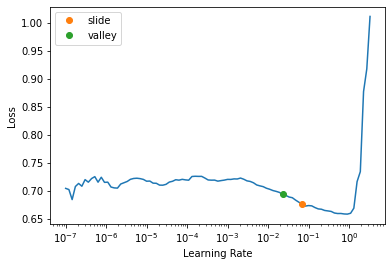

In [79]:
learn.lr_find(suggest_funcs=(slide, valley))

In [105]:
learn.fit(5, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.541449,0.557695,0.710000,00:00
1,0.538037,0.567792,0.720000,00:00
2,0.535741,0.571190,0.725000,00:00
3,0.536574,0.549333,0.715000,00:00
4,0.537634,0.567759,0.715000,00:00


## Exemplo no Gradio

In [ ]:
! pip install -q gradio

In [104]:
import gradio as gr
import pandas as pd

def predict(credit_history,property_magnitude, housing, credit_amount, num_dependents, age):

    data = [[credit_history, property_magnitude, housing, float(credit_amount), int(num_dependents), int(age)]]

    row_df = pd.DataFrame(data,columns=['credit_history','property_magnitude', 'housing', 'credit_amount', 'num_dependents', 'age'])
    
    row, clas, probs = learn.predict(row_df.iloc[0])
    if probs[0] < 0.5:
        return "good"
    else:
        return "bad"

gr.Interface(
    fn=predict,
    title="Predict Credit Customers",
    allow_flagging="never",
    inputs=[
        gr.inputs.Radio(["critical/other existing credit", "existing paid", "delayed previously"], label="credit_history", default="critical/other existing credit"),
        gr.inputs.Radio(["car", "real estate", "life insurance", "no known property"], label="property_magnitude", default="car"),
        gr.inputs.Radio(["for free", "own"], label="housing", default="own"),
        gr.inputs.Number(default=4576.00, label="credit_amount"),
        gr.inputs.Number(default=1, label="num_dependents"),
        gr.inputs.Number(default=27, label="age")
    ],
    outputs="text").launch()

/opt/conda/lib/python3.7/site-packages/gradio/inputs.py:186: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/opt/conda/lib/python3.7/site-packages/gradio/inputs.py:193: UserWarning: `optional` parameter is deprecated, and it has no effect
  optional=optional,
/opt/conda/lib/python3.7/site-packages/gradio/inputs.py:60: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/opt/conda/lib/python3.7/site-packages/gradio/inputs.py:62: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(value=default, lab

Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on local URL:  http://127.0.0.1:7865
Running on public URL: https://a9ef17cbca04f37169.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


## Exportando o modelo

In [102]:
learn.export('model.pkl')

## Link Hugging Face

[HugginFace](https://huggingface.co/spaces/JoaoElvas/Credit_Risk_Custumer)